In [59]:
import torch 
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time as time


from scipy.special import erf,erfc

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


In [61]:
class NN(nn.Module):
    def __init__(self,layers):
        super().__init__()

        self.activation = nn.SiLU()
        self.loss_function = nn.MSELoss(reduction = 'mean')
        self.layers = layers

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])


        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)



    def forward(self,x,t):
        a = torch.cat([x,t], dim = 1)

        for i in range(len(self.layers)-2):
            L = self.linears[i](a)
            a = self.activation(L)

        b = self.linears[-1](a)


        return b

In [62]:
layers = np.array([2,200,200,200,200,200,1])
net_T = NN(layers).to(device)

In [63]:
# Define LHS

def lhs(n:int, d:int, low: np.ndarray, high: np.ndarray) -> np.ndarray:

    low = np.asarray(low).reshape(1,d)
    high = np.asarray(high).reshape(1,d)

    m = np.random.rand(n,d)

    a = np.linspace(0,1,n, endpoint = False).reshape(n,1)
    b = np.linspace(1/n,1,n).reshape(n,1)

    pts =  a + m*(b-a)

    for j in range(d):
        np.random.shuffle(pts[:,j])

    return low+(high-low)*pts


In [64]:
# Create Collocation Points




# For Graphite part (x = -0.4 to 0)

X = lhs(n = 10000, d=2, low=np.array([-0.4,0]), high = np.array([0,10]))

x_f_g = (X[:,[0]])
x_f_g = torch.tensor(x_f_g, dtype = torch.float32, device = device, requires_grad=True)

t_f_g = (X[:,[1]])
t_f_g = torch.tensor(t_f_g, dtype = torch.float32, device = device, requires_grad=True) 





# For Aluminium part (x = 0 to 0.4)

X = lhs(n = 10000, d=2, low=np.array([0,0]), high = np.array([0.4,10]))

x_f_A = (X[:,[0]])
x_f_A = torch.tensor(x_f_A, dtype = torch.float32, device = device, requires_grad=True)

t_f_A = (X[:,[1]])
t_f_A = torch.tensor(t_f_A, dtype = torch.float32, device = device, requires_grad=True)



In [65]:
# Normalize Inputs and Outputs


def net_T_norm(x,t):
    x_n = x/0.4
    t_n = t/10.0

    T_n = net_T(x_n, t_n)

    T = T_n * (973.15-298.15) + 298.15


    return T

In [66]:
def bc_loss():
    x_l = torch.full((500,1), -0.4, device = device, dtype = torch.float32)
    x_r = torch.full((500,1), 0.4, device = device, dtype = torch.float32)
    


    


    # t = torch.linspace(5,10,500).view(-1,1)
    # t = torch.tensor(t, dtype = torch.float32, device = device)

    X = lhs(n = 500, d=1, low=np.array([0.0]), high = np.array([10.0]))

    t = torch.tensor(X, dtype = torch.float32, device = device)


    # T_left = net_T_norm(x_l,t)
    # T_right = net_T_norm(x_r,t)


    # res_bc_1 = T_left - 298.15
    # loss_bc_1 = torch.mean(res_bc_1 ** 2)

    # res_bc_2 = T_right - 973.15
    # loss_bc_2 = torch.mean(res_bc_2 ** 2)


    T_left = net_T_norm(x_l,t) 
    T_left = (T_left - 298.15) / (973.15 - 298.15)



    T_right = net_T_norm(x_r,t) 
    T_right = (T_right - 298.15) / (973.15 - 298.15)



    res_bc_1 = T_left - 0.0
    loss_bc_1 = torch.mean(res_bc_1 ** 2)

    res_bc_2 = T_right - 1.0
    loss_bc_2 = torch.mean(res_bc_2 ** 2)


    



    loss_bc = loss_bc_1 + loss_bc_2


    return loss_bc



In [67]:
def ic_loss():


    t_0 = torch.zeros(10000,1)
    t_0 = torch.tensor(t_0, dtype = torch.float32, device = device)


    X_L = lhs(n = 10000, d=1, low=np.array([-0.4]), high = np.array([0.0]))
    x_left = torch.tensor(X_L, dtype = torch.float32, device = device)


    X_R = lhs(n = 10000, d=1, low=np.array([0.0]), high = np.array([0.4]))
    x_right = torch.tensor(X_R, dtype = torch.float32, device = device)

    
   


    # T_initial_left = net_T_norm(x_left,t_0) 
    # T_initial_right = net_T_norm(x_right,t_0) 


    T_initial_left = net_T_norm(x_left,t_0) 
    T_initial_left = (T_initial_left - 298.15) / (973.15 - 298.15)



    T_initial_right = net_T_norm(x_right,t_0) 
    T_initial_right = (T_initial_right - 298.15) / (973.15 - 298.15)



    res_ic_1 = T_initial_left - 0.0
    loss_ic_1 = torch.mean(res_ic_1 ** 2)

    res_ic_2 = T_initial_right - 1.0
    loss_ic_2 = torch.mean(res_ic_2 ** 2)


    # res_ic_1 = T_initial_left - 298.15
    # loss_ic_1 = torch.mean(res_ic_1 ** 2)

    # res_ic_2 = T_initial_right - 973.15
    # loss_ic_2 = torch.mean(res_ic_2 ** 2)



    loss_ic = loss_ic_1 + loss_ic_2


    return loss_ic

In [68]:
def pde_loss(x_f_g,t_f_g, x_f_A, t_f_A):

    rho_g = 2200
    c_p_g = 1700
    k_g = 100


    rho_a = 2555
    c_p_a = 1190
    k_s_a = 211
    k_l_a = 91


    L_a = 398000




    ## For graphite part (x = -0.4 to 0), there is no phase change. So, pure heat conduction equation.

    T_g = net_T_norm(x_f_g, t_f_g)
    T_g_t = torch.autograd.grad(T_g, t_f_g, torch.ones_like(T_g), create_graph=True)[0]

    T_g_x = torch.autograd.grad(T_g, x_f_g, torch.ones_like(T_g), create_graph=True)[0]
    T_g_x_x = torch.autograd.grad(T_g_x, x_f_g, torch.ones_like(T_g_x), create_graph=True)[0]

    
    
    
    # res_pde_1 = (rho_g*c_p_g*T_g_t) - (k_g * T_g_x_x)

    res_pde_1 = (T_g_t) - (k_g * T_g_x_x)/(rho_g*c_p_g)               # Making it dimensionless
    loss_pde_1 = torch.mean(res_pde_1 ** 2)





    ## For Aluminium part (x = 0 to 0.4), energy calculated with Latent Heat (L)

    T_a = net_T_norm(x_f_A, t_f_A)
    T_a_t = torch.autograd.grad(T_a, t_f_A, torch.ones_like(T_a), create_graph=True)[0]
    T_a_x = torch.autograd.grad(T_a, x_f_A, torch.ones_like(T_a), create_graph=True)[0]
    T_a_x_x = torch.autograd.grad(T_a_x, x_f_A, torch.ones_like(T_a_x), create_graph=True)[0]


    T_melt = 933.15

    dT = 20.0

    T_s = T_melt - 0.5*dT
    T_l = T_melt + 0.5*dT


    f = ((T_a - T_s) / (T_l - T_s)).clamp(0.0, 1.0)

    inv_dT = 1.0 / (T_l - T_s)
    f_T = torch.where((T_a >= T_s) & (T_a <= T_l), torch.full_like(T_a, inv_dT), torch.zeros_like(T_a))


    k = k_s_a * (1.0 - f) + k_l_a * f

    k_x = torch.autograd.grad(k,x_f_A,torch.ones_like(k), create_graph=True)[0]


    # res_pde_2 = (rho_a * c_p_a * T_a_t) + (rho_a * L_a * f_T * T_a_t) - (k * T_a_x_x + k_x*T_a_x)



    res_pde_2 = (T_a_t) + (L_a * f_T * T_a_t)/(c_p_a) - (k * T_a_x_x + k_x*T_a_x)/(rho_a*c_p_a)             # Making it dimensionless
    loss_pde_2 = torch.mean(res_pde_2**2)






    loss_pde = loss_pde_1 + loss_pde_2



    return loss_pde


In [ ]:
# def add_losses():
#     loss_bc = bc_loss()
#     loss_ic = ic_loss()
#     loss_pde = pde_loss(x_f_g, t_f_g, x_f_A, t_f_A)


#     w_pde = 1.0


#     total_loss = loss_bc + loss_ic + w_pde*loss_pde


#     return total_loss

In [69]:
optimizer = torch.optim.Adam(net_T.parameters(), lr = 0.0001 )

In [70]:
torch.manual_seed(42)

In [71]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [72]:
start_time = time.time()

num_epochs = 20000

total_loss_list = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    

    # total_loss = add_losses()
    loss_bc = bc_loss()
    loss_ic = ic_loss()
    loss_pde = pde_loss(x_f_g, t_f_g, x_f_A, t_f_A)

    total_loss = loss_bc + loss_ic + loss_pde

    total_loss.backward()
    

    optimizer.step()
    
    

    
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}:  total loss={total_loss.item():.3e}")
        print(loss_bc.item(), loss_ic.item(), loss_pde.item())

    
end_time = time.time()

print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

/tmp/ipykernel_404960/478187250.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_0 = torch.tensor(t_0, dtype = torch.float32, device = device)


Epoch 0:  total loss=2.381e+00
0.9967023134231567 1.0013790130615234 0.38331514596939087
Epoch 500:  total loss=1.656e-01
0.005203206092119217 0.15132103860378265 0.009052523411810398
Epoch 1000:  total loss=1.628e-01
0.005814532749354839 0.15041081607341766 0.006620625965297222
Epoch 1500:  total loss=1.965e-01
0.004979310557246208 0.15147224068641663 0.04001312702894211
Epoch 2000:  total loss=1.601e-01
0.00632008071988821 0.14978580176830292 0.004025260452181101
Epoch 2500:  total loss=1.596e-01
0.006740084849298 0.1494002342224121 0.0034892854746431112
Epoch 3000:  total loss=1.593e-01
0.0069089834578335285 0.14933159947395325 0.003108356613665819
Epoch 3500:  total loss=1.592e-01
0.0069777462631464005 0.14935511350631714 0.002830374985933304
Epoch 4000:  total loss=1.673e-01
0.003986458759754896 0.15360984206199646 0.009708981029689312
Epoch 4500:  total loss=1.589e-01
0.0071458155289292336 0.14938795566558838 0.0023400508798658848
Epoch 5000:  total loss=1.588e-01
0.0072094257920

In [73]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  2340.83 MB


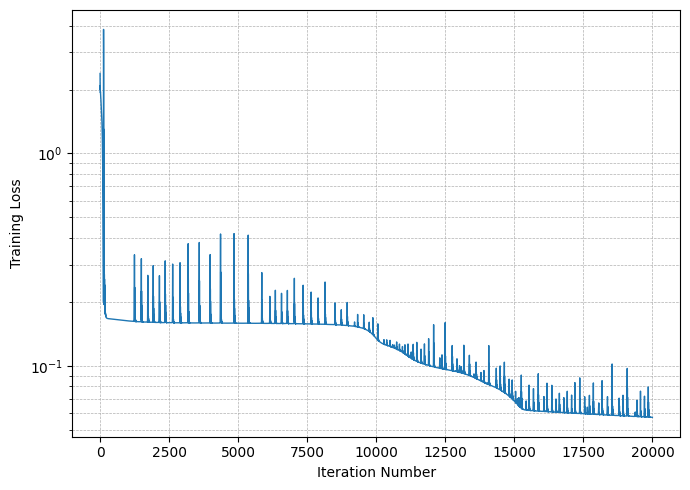

In [74]:
loss = np.array(total_loss_list)
iters = np.arange(len(loss))


plt.figure(figsize = (7,5))
plt.plot(iters, loss, linewidth = 1.0)

plt.yscale('log')
plt.xlabel('Iteration Number')
plt.ylabel('Training Loss')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

In [75]:
# Define the analytic Functions

def analytic(x,t):
    x = np.asarray(x).reshape(-1)
    t = float(t)

    eps = 1e-12

    rt = np.sqrt(max(eps,t))



    #Interface location

    x_star = 7.095e-3 * rt

    T_m = 769.95 + 471.8 * erf((96.69*x)/rt)
    T_s = 769.95 + 360.2 * erf((60.02*x)/rt)
    T_l = 973.15 - 111.4 * erfc((91.39*x)/rt)



    T = np.empty_like(x)


    mask_mold = (x <= 0.0)
    mask_solid = (x > 0.0) & (x <= x_star)
    mask_liq = (x > x_star)


    T[mask_mold] = T_m[mask_mold]
    T[mask_solid] = T_s[mask_solid]
    T[mask_liq] = T_l[mask_liq]




    return T.reshape(-1,1)

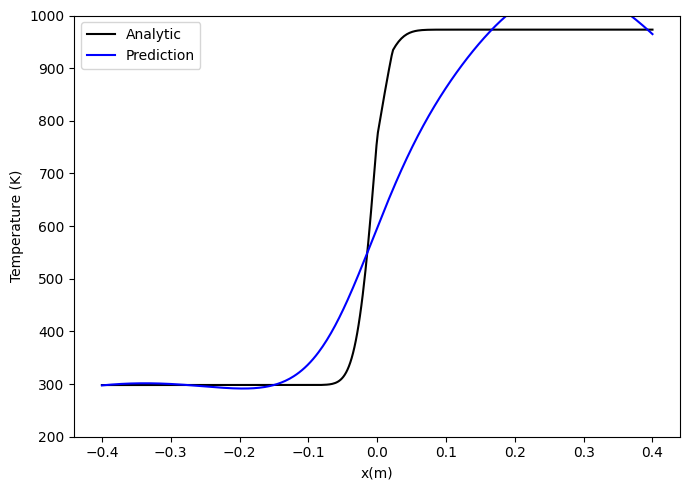

In [76]:
t_plot = 10.0

x = np.linspace(-0.4, 0.4, 400).reshape(-1,1)
t = np.full_like(x,t_plot)

x_t = torch.tensor(x, dtype = torch.float32, device = device)
t_t = torch.tensor(t, dtype = torch.float32, device = device)



T_a = analytic(x,t_plot)

net_T.eval()

with torch.no_grad():
    T_plot = net_T_norm(x_t, t_t).cpu().numpy()



plt.figure(figsize = (7,5))

plt.plot(x,T_a, 'k-', linewidth = 1.5, label = 'Analytic')
plt.plot(x,T_plot, 'b-', linewidth = 1.5, label = 'Prediction')

plt.xlabel('x(m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.ylim(200,1000)
plt.tight_layout()
plt.show()







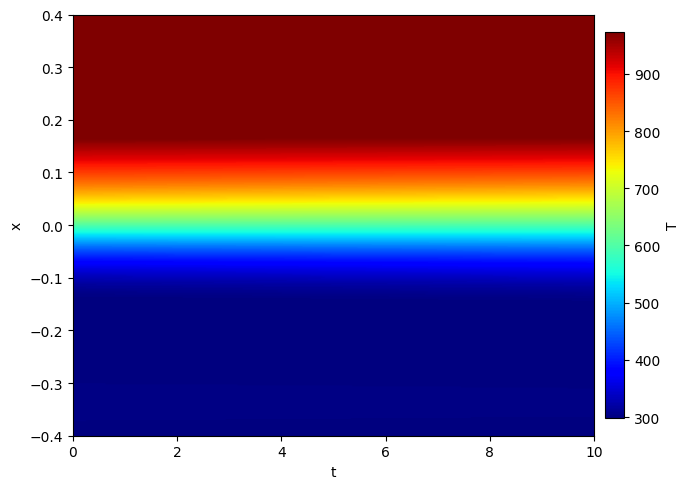

In [85]:
x = np.linspace(-0.4,0.4,400).reshape(-1,1)
t = np.linspace(0,10,400).reshape(-1,1)

T_grid = np.zeros((400,400), dtype = np.float32)


net_T.eval()


with torch.no_grad():
    x_t = torch.tensor(x, dtype = torch.float32, device = device)

    for i in range(len(t)):
        t_t = torch.full_like(x_t, t[i,0])

        T_pred = net_T_norm(x_t, t_t).cpu().numpy().reshape(-1)

        T_grid[:,i] = T_pred



plt.figure(figsize = (7,5))


im = plt.imshow(T_grid, origin = 'lower', aspect  = 'auto', extent = [t.min(), t.max(), x.min(), x.max()], vmin = 298.15, vmax = 973.15, cmap = 'jet')



plt.xlabel('t')
plt.ylabel('x')

cbar = plt.colorbar(im, fraction = 0.035, pad = 0.02)

cbar.set_label('T')


plt.tight_layout()
plt.show()